# Bibliotheken importeren

In [110]:
import pandas as pd
import random 
import pyodbc
import sqlite3
import matplotlib.pyplot as plt

# !!! SKLEARN IS DEPRECATED, PIP INSTALL "scikit-learn" INSTEAD !!!
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Data inlezen en kolommen selecteren

In [111]:
# !!! HOEFT DIT ALLEEN TE RUNNEN WANNEER DE DATA NOG NIET IN DE SQLITE DATABASE STAAT !!!


In [112]:
sqlite_conn = sqlite3.connect('../data/johari.db')
df = pd.read_sql('SELECT * FROM ORDER_DETAILS', sqlite_conn)

df = df.loc[:, ['ORDER_DETAILS_id', 'ORDER_PRODUCT_id', 'ORDER_STAFF_id', 'ORDER_METHOD_id', 'ORDER_RETAILER_id', 'ORDER_PRODUCT_margin', 'ORDER_unit_cost', 'ORDER_unit_sale', 'ORDER_PRODUCT_cost', 'ORDER_total_profit', 'ORDER_total_price_before_sales', 'ORDER_total_price_after_sales', 'ORDER_total_sale_amount', 'ORDER_timestamp', 'ORDER_quantity']] # Alleen de benodigde kolommen
df.head()

,ORDER_DETAILS_id,ORDER_PRODUCT_id,ORDER_STAFF_id,ORDER_METHOD_id,ORDER_RETAILER_id,ORDER_PRODUCT_margin,ORDER_unit_cost,ORDER_unit_sale,ORDER_PRODUCT_cost,ORDER_total_profit,ORDER_total_price_before_sales,ORDER_total_price_after_sales,ORDER_total_sale_amount,ORDER_timestamp,ORDER_quantity
0,47737,1,44,7,21,0.33,4.38,6.59,6.59,185.64,553.56,553.56,0.00,2020-08-16 00:00:00,84
1,47738,1,50,7,9,0.33,4.38,6.59,6.59,278.46,830.34,830.34,0.00,2020-04-05 00:00:00,126
2,47739,1,50,3,19,0.33,4.38,6.03,6.59,201.30,803.98,735.66,68.32,2020-04-16 00:00:00,122
3,47740,1,50,4,4,0.33,4.38,6.59,6.59,269.62,803.98,803.98,0.00,2020-10-01 00:00:00,122
4,47741,1,43,4,21,0.33,4.38,5.26,6.59,239.36,1792.48,1430.72,361.76,2020-04-23 00:00:00,272


# One-hot encoding van onafhankelijke niet-numerieke variabelen

In [113]:


df['ORDER_timestamp'] = pd.to_datetime(df['ORDER_timestamp'])
# Extract month from the timestamp
df['month'] = df['ORDER_timestamp'].dt.month
# Perform one-hot encoding on the month
dummies_dataframe = pd.get_dummies(df['month'], prefix='month')

dummies_dataframe.head()

,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,False,False,False,False,False,False,False,True,False,False,False,False
1,False,False,False,True,False,False,False,False,False,False,False,False
2,False,False,False,True,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,True,False,False
4,False,False,False,True,False,False,False,False,False,False,False,False


In [114]:
# Concatenate the original dataframe with the dummies dataframe
df = pd.concat([df, dummies_dataframe], axis=1)

# Drop the original timestamp column
df = df.drop(columns=['ORDER_timestamp'])

# Adjust column order
df = df.loc[:, ['ORDER_DETAILS_id', 'ORDER_PRODUCT_id', 'ORDER_STAFF_id', 'ORDER_METHOD_id', 'ORDER_RETAILER_id', 'ORDER_PRODUCT_margin', 'ORDER_unit_cost', 'ORDER_unit_sale', 'ORDER_PRODUCT_cost', 'ORDER_total_profit', 'ORDER_total_price_before_sales', 'ORDER_total_price_after_sales', 'ORDER_total_sale_amount', 'ORDER_quantity'] + list(dummies_dataframe.columns)]

df.head()

,ORDER_DETAILS_id,ORDER_PRODUCT_id,ORDER_STAFF_id,ORDER_METHOD_id,ORDER_RETAILER_id,ORDER_PRODUCT_margin,ORDER_unit_cost,ORDER_unit_sale,ORDER_PRODUCT_cost,ORDER_total_profit,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,47737,1,44,7,21,0.33,4.38,6.59,6.59,185.64,...,False,False,False,False,False,True,False,False,False,False
1,47738,1,50,7,9,0.33,4.38,6.59,6.59,278.46,...,False,True,False,False,False,False,False,False,False,False
2,47739,1,50,3,19,0.33,4.38,6.03,6.59,201.30,...,False,True,False,False,False,False,False,False,False,False
3,47740,1,50,4,4,0.33,4.38,6.59,6.59,269.62,...,False,False,False,False,False,False,False,True,False,False
4,47741,1,43,4,21,0.33,4.38,5.26,6.59,239.36,...,False,True,False,False,False,False,False,False,False,False


# Verticaal en horizontaal snijden

In [115]:
X = df.drop('ORDER_quantity', axis=1) # Onafhankelijke variabelen
y = df.loc[:, ['ORDER_quantity']] # Afhankelijke variabele
y.head()

,ORDER_quantity
0,84
1,126
2,122
3,122
4,272


In [116]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.15,
    random_state=42
) # Data splitsen in trainings- en testset

# Regressiemodel bouwen

In [117]:
reg_model = linear_model.LinearRegression() # Regressiemodel
reg_model = LinearRegression().fit(X_train, y_train) # Model trainen
reg_model

LinearRegression()

In [118]:
y_pred = reg_model.predict(X_test) # Voorspellingen maken
y_pred

array([[31.22089104],
       [14.23036055],
       [68.63969222],
       ...,
       [51.66464164],
       [53.82124047],
       [71.41603683]])

In [119]:
prediction_df = pd.DataFrame(y_pred) # Voorspellingen in dataframe zetten
prediction_df = prediction_df.rename(columns={0: 'Predicted_Order_Quantity'}) # Kolomnaam aanpassen
prediction_df.head()

,Predicted_Order_Quantity
0,31.220891
1,14.230361
2,68.639692
3,62.771910
4,65.024537


In [120]:
y_test_prediction_merge = pd.concat([y_test.reset_index()['ORDER_quantity'], prediction_df], axis=1) # Voorspellingen en echte waarden samenvoegen
y_test_prediction_merge.loc[y_test_prediction_merge['Predicted_Order_Quantity'].notna(), :] # Alleen de voorspellingen tonen
y_test_prediction_merge

,ORDER_quantity,Predicted_Order_Quantity
0,10,31.220891
1,8,14.230361
2,36,68.639692
3,30,62.771910
4,122,65.024537
...,...,...
6455,20,39.609924
6456,36,79.892451
6457,12,51.664642
6458,16,53.821240


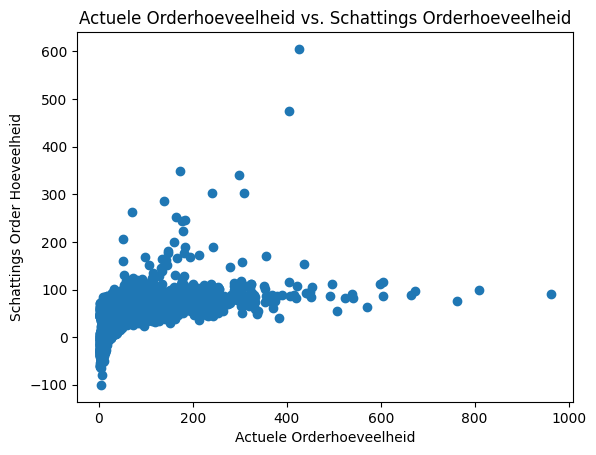

In [121]:
plt.scatter(y_test_prediction_merge['ORDER_quantity'], y_test_prediction_merge['Predicted_Order_Quantity']) # Scatterplot
plt.xlabel('Actuele Orderhoeveelheid')
plt.ylabel('Schattings Order Hoeveelheid')
plt.title('Actuele Orderhoeveelheid vs. Schattings Orderhoeveelheid')
plt.show()

In [122]:
mean_squared_error(y_test, y_pred) # Mean Squared Error, lager is beter

2697.32413180415

In [123]:
mean_absolute_error(y_test, y_pred) # Mean Absolute Error, lager is beter

30.071654066669698

In [142]:
sqlite_conn.close()